# GRASP, Greedy y Búsqueda Local

Muchos problemas de optimización combinatoria son NP-completos, como se vió la clase pasada. Existen diversas estrategias para poder aproximarnos al óptimo global, muchas de ellas consistiendo en movimiento locales a partir de un punto inicial.

## GRASP en el *Travelling Salesman Problem*

Retomando el ejemplo de la clase pasada, asumamos que somos un emprendedor que debe distribuir su productos a cafeterías. En esta instancia, nos centraremos en la comuna de Santiago

In [51]:
import osmnx as ox
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from helpers import obtenerGrafo, graficar

In [39]:
G = obtenerGrafo(200, noise_level=0.9)

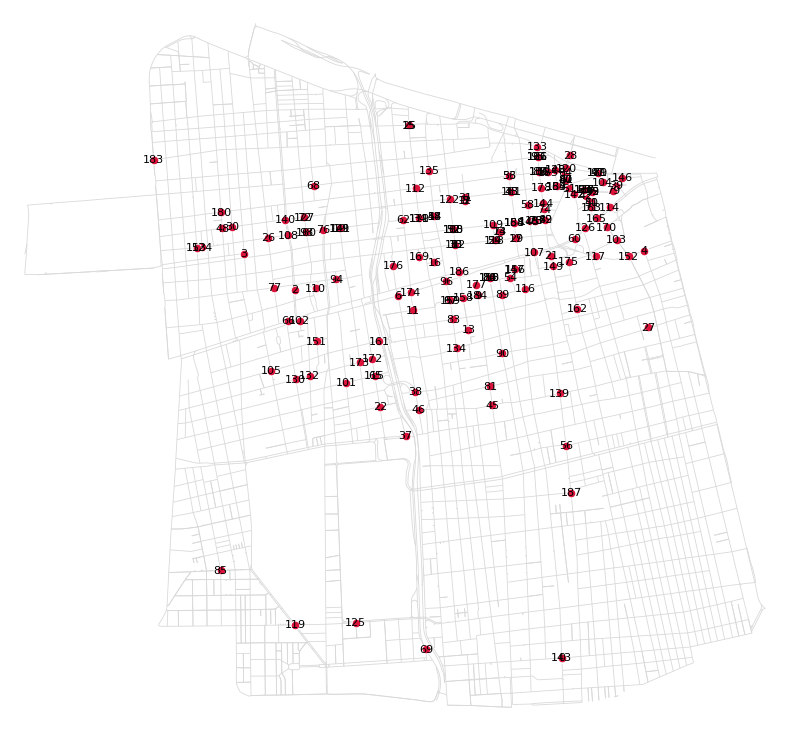

In [41]:
graficar(G, labels=False, edge_alpha=0.00)

Este ejercicio nos ayudará a ver cómo acercarnos a la solución óptima a partir de una solución factible inicial. En específico, vamos a querer ver como GRASP nos permite explorar mejores soluciones a partir del `nearest_neighbor`. *¿Es siempre conveniente utilizar GRASP?* 

En la clase pasada vimos como las heurísticas nos ayudan a acercarnos a una solución factible y óptima. GRASP nos ayudará a explorar mejores soluciones. En específico, introducimos **aleatoriedad** y nos vamos armando una ruta óptima. 

1. Elegimos un $\alpha\in [0,1]$ tal que hacemos un `nearest_neighbor` tal que incorporamos al primer vecino que esté por debajo del siguiente threshold:

$$\text{Threshold}=\text{Costo mínimo} + \alpha (\text{Costo máximo}-\text{Costo mínimo})$$

2. A partir de esta nueva solución inicial, aplicamos `2-opt`. Recorremos el tour desde el primer nodo y evaluamos las aristas adyacentes. Si la permutación entre ambas aristas hace que la función objetivo mejore, se hace el cambio y se vuelve a recorrer el tour hasta que no se puedan hacer más permutaciones.

Un ejemplo breve es con el siguiente tour $[0,1,2,3,4,5,0]$. Si elegimos las aristas $(1,2)$ y $(3,4)$, el swap invertiría el tramo tal que el tramo se convertiría de: 

- Original: $1 - 2 - 3 - 4 - 5$
- Con swap: $1 - 4 - 3 - 2 - 5$

Luego del swap, quedaría el tour $[0, 1, 4 , 3, 2, 5, 0]$. Así, se volvería a recorrer el tour, evaluando las primeras (nuevas) opciones $0 - 1$ y $4 - 3$

In [52]:
import random


def w(G, u, v):
    return G[u][v].get("weight", 0)


def cycle_cost_nodes(G, nodes):
    """
    Suma los pesos a lo largo del ciclo definido por 'nodes' (sin repetir el inicio al final).

    Parámetros:
    ------
    G : nx.Graph
        Grafo obtenido de 'obtenerGrafo'
    nodes : list

    Retorna:
    -------
    float
    """
    n = len(nodes)
    total = 0.0
    for i in range(n):
        u = nodes[i]
        v = nodes[(i + 1) % n]
        total += w(G, u, v)
    return total  # costo total del ciclo


def close_tour(nodes):
    """
    Devuelve la lista 'nodes' cerrada (último = primero).

    Parámetros:
    ------
    nodes : list

    Retorna:
    -------
    list
    """
    return nodes + [nodes[0]]


def two_opt(G, nodes):
    """
    Aplica 2-opt (first-improvement) hasta que no haya mejoras.

    Parámetros:
    ------
    G : nx.Graph
        Grafo obtenido con obtenerGrafo
    nodes : list
        Lista de nodos

    Retorna:
    -------
    list
    """
    """ 
    Programar 
    """


def tsp_grasp(G, alpha=0.3, seed=None):
    """
    Construye un tour con Nearest Neighbor aleatorizado por RCL y lo mejora con 2-opt.

    Parámetros:
    ------
    G : nx.Graph
        Grafo obtenido con obtenerGrafo
    alpha : float
        (0<=alpha<=1) controla el umbral de la RCL
    seed : int|None  semilla para reproducibilidad

    Retorna:
    -------
    (tour_cerrado:list, costo:float)
    """
    rng = random.Random(seed)
    tour = list(G.nodes())
    rng.shuffle(tour)  # Aleatoriedad
    n = len(tour)  # cantidad de nodos

    # -----
    # Construcción: para cada posición i, elegimos la "siguiente" ciudad
    # -----
    for i in range(n - 1):
        u = tour[i]

        # Calculamos el costo mínimo y máximo entre candidatos
        c_min, c_max = float("inf"), float("-inf")
        for j in range(i + 1, n):  # mirar todos los no fijados
            cost = w(G, u, tour[j])  # distancia u -> candidato
            if cost < c_min:
                c_min = cost  # mínimo observado
            if cost > c_max:
                c_max = cost  # máximo observado

        # umbral de la RCL: acepta "casi mejores" según alpha
        threshold = c_min + alpha * (c_max - c_min)

        # elegimos el PRIMER candidato (en este orden aleatorio) que cumpla el umbral
        nxt = (
            i + 1
        )  # Notemos que igual garantiza randomness, elegimos el índice más chico que ya es aleatorio
        while w(G, u, tour[nxt]) > threshold:
            nxt += 1  # avanzar hasta que caiga en la RCL

        # colocar ese candidato como el siguiente en el tour
        tour[i + 1], tour[nxt] = tour[nxt], tour[i + 1]

    # -----
    # Hacemos la explotación con la mejora local
    # -----
    tour = two_opt(G, tour)
    cost = cycle_cost_nodes(G, tour)

    return close_tour(tour), cost  # devolvemos tour cerrado + costo

Dado el código GRASP, nos interesa visualizar como va explorando las distintas soluciones. Para una cantidad fija de iteraciones (10), nos interesaría saber como la aleatoriedad ayuda a escapar de óptimos locales. 

Fijaremos en rojo la solución que encuentra el nearest neighbor y mostraremos las soluciones que se encuentran al explorar con grasp.

In [6]:
from networkx.algorithms import approximation as approx


def tour_cost(G, tour):
    return sum(G[u][v].get("weight", 1.0) for u, v in zip(tour, tour[1:]))


def graficarGRASP(G, iteraciones):
    # -----
    # Nearest neighbor del enfoque greedy
    # -----
    source_nn = next(iter(G.nodes()))  # elijo una fuente fija (puedes cambiarla)
    tour_nn = approx.greedy_tsp(G, weight="weight", source=source_nn)  # tour cerrado
    cost_nn = tour_cost(G, tour_nn)  # costo NN (referencia)

    # -----
    # Nos definimos el eje X
    # -----
    alphas = np.round(np.arange(0.0, 1.0 + 1e-9, 0.2), 1)  # 0.0, 0.2, ..., 1.0
    runs_per_alpha = iteraciones
    rng = random.Random(7)

    xs, ys = [], []  # Almacenaré todos los puntos encontrados

    for a in alphas:
        for r in range(runs_per_alpha):
            # semilla distinta por corrida (para diversificar entre runs y alphas)
            seed = 10_000 + int(round(a * 10)) * 100 + r  # Fórmula random
            tour_a, cost_a = tsp_grasp(G, alpha=a, seed=seed)
            # Movemos un poquito los puntos para que no se superpongan
            xj = float(a) + (rng.random() - 0.5) * 0.02
            xs.append(xj)
            ys.append(cost_a)

    # -----
    # GRASP vs Nearest Neighbor
    # -----
    plt.figure(figsize=(7, 4))

    plt.scatter(
        xs,
        ys,
        s=30,
        alpha=0.9,
        label="GRASP ({} corridas por alpha)".format(iteraciones),
    )
    plt.axhline(y=cost_nn, color="red", linewidth=2, label="Nearest Neighbor")

    plt.xlabel("alpha (umbral de RCL)")
    plt.ylabel("Costo del tour")
    plt.title("Exploración de soluciones GRASP vs. Nearest Neighbor")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

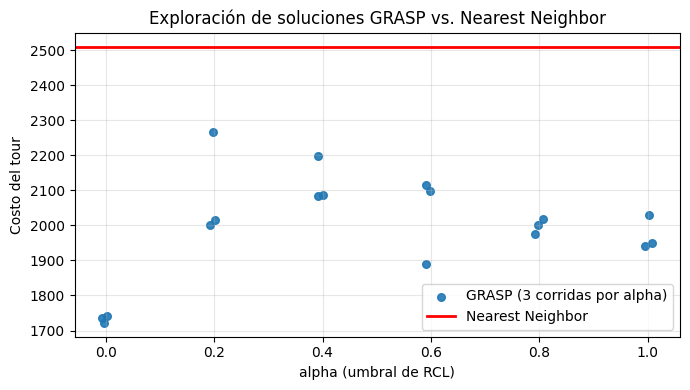

In [129]:
graficarGRASP(G, 3)

Si nos fijamos, la solución menos aleatorizada (con $\alpha = 0$) nos da la mejor solución para el problema de recorrido de ciudades. Esto se debe porque la mayoría de los nodos cumplen con la **desigualdad triangular**. Esto implica que la solución greedy ya es lo suficientemente buena, puesto que existen óptimos locales. Notemos que, en este caso, GRASP nos está ayudando a determinar como está compuesta nuestra instancia.

Lo anterior se conoce como el trade-in entre **explorar** y **explotar**. Por un lado, un $\alpha$ más alto nos permite explorar más soluciones, mientras que las iteraciones permiten explotar estas soluciones. 

La idea es que, dado que conocemos nuestro $\alpha$ óptimo, intentar explotar sus soluciones al imponer varias iteraciones.

En el siguiente bloque, grafica como va mejorando la mejor solución en función del parámetro de exploración óptimo que encontramos anteriormente

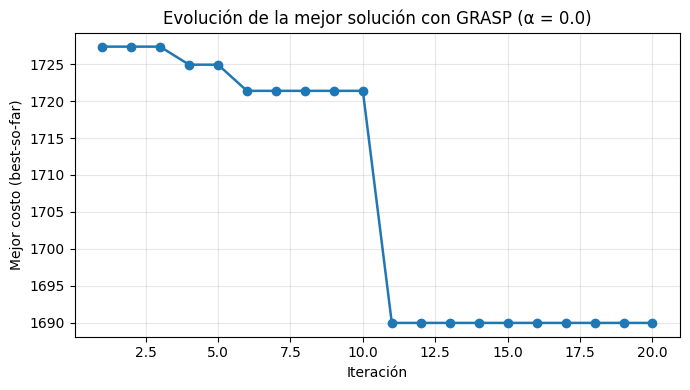

In [130]:
import random
import matplotlib.pyplot as plt

# -----
# Parámetros del experimento
# -----
alpha = 0.0
T = 20
base_seed = 12345

# -----
# Iteramos entre todos los trials
# -----
best_so_far = []
current_best = float("inf")

for t in range(1, T + 1):
    seed = base_seed + t
    tour, cost = tsp_grasp(G, alpha=alpha, seed=seed)
    # actualizamos el mejor encontrado hasta ahora
    if cost < current_best:
        current_best = cost
    best_so_far.append(current_best)

# -----
# Gráficar
# -----
plt.figure(figsize=(7, 4))
plt.plot(range(1, T + 1), best_so_far, marker="o", linewidth=1.8)
plt.xlabel("Iteración")
plt.ylabel("Mejor costo (best-so-far)")
plt.title(f"Evolución de la mejor solución con GRASP (α = {alpha})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Veamos que, a pesar de trabajar con $\alpha = 0$, las soluciones cambian. Esto se debe que GRASP, aún así, introduce aleatoriedad al cambiar el **nodo de inicio** y barajar la lista de nodos a incorporar.

Por el otro lado, veamos que al aumentar las iteraciones pareciera llegar a una cota mínima. *¿Será el óptimo?* 

Unas de las gracias de los problemas NP completos es que probar la optimalidad es igualmente compleja que encontrar la propia optimalidad

# Problema del Max Cut

El problema del max cut es fundamental en el área de telecomunicaciones y computación paralela. Dado un grafo ponderado $G=(V,E,w)$, queremos **partir** el conjunto de nodos $V$ en dos grupos $\bar{S}=V\backslash S$ para **maximizar la suma de pesos de las aristas que cruzan el corte**. Así, sea $x_v\in\lbrace 0,1\rbrace$ la variable binaria que nos indica el lado de $v$, una arista $(u,v)$ cruza si $x_u\neq x_v$, se busca maximizar 

$$\max\sum_{(u,v)\in E}w_{uv}\cdot\mathbf{1}[x_u\neq x_v]$$ 

Este problema también es NP-completo, por lo que exploraremos como resolverlo a través de heurísticas localizadas. En específico, un vencindario llegaría a ser invertir el lado de un vértice.

Para explorar el problema nos generaremos datos sintéticos y funciones auxiliares que nos diga la ganancia por hacer una inversión de vértices y la función objetivo. 

Los pesos de las aristas seran proporcional a $\exp(\text{distancia}^2)$ con alta presencia de óptimos locales.

In [44]:
import math
import random

# -----
# Generación de grafo sintético
# -----
G = nx.random_geometric_graph(80, radius=0.32, seed=7)  # imponemos varios triángulos
pos = nx.get_node_attributes(G, "pos")
for u, v in G.edges():
    d = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))
    G[u][v]["weight"] = math.exp(-(d**2) / 0.003)  # (cortas MUY pesadas)

anchors = random.sample(list(G.nodes()), 9)  # 9 = impar
for i in range(9):
    u, v = anchors[i], anchors[(i + 1) % 9]
    if not G.has_edge(u, v):
        G.add_edge(u, v)
    G[u][v]["weight"] = max(G[u][v].get("weight", 0.0), 1.8)  # peso alto en el backbone


# -----
# Suma de los pesos del cruce, función objetivo
# -----
def cut_weight(G, side):
    """
    Obtiene la función objetivo

    Parámetros
    ----------
    G: nx.Graph
        Grafo generado previamente con los datos sintéticos

    side: Dict
        Diccionario que nos dice si un nodo pertenece a algún lado u otro

    Retorno
    -------
    float: El valor del peso de las aristas que cruzan los lados.

    """
    val = 0.0
    for u, v, w in G.edges(data="weight", default=1.0):
        if side[u] != side[v]:
            val += w
    return val


def delta_flip(G, side, v):
    """
    Ganancia neta al cambiar de lado un vértice.
    Fórmula: sum_pesos_hacia_mismo - sum_pesos_hacia_opuesto
    Si delta > 0, conviene flippear.

    Parámetros
    ----------
    G: nx.Graph
        Grafo generado previamente con los datos sintéticos

    side: Dict
        Diccionario que nos dice si un nodo pertenece a algún lado u otro

    v: int
        Nodo a evaluar

    Retorno
    -------

    float: Retorna la resta de las aristas que pasan hacia un lado menos las que pasan hacia el otro
    """
    same, diff = 0.0, 0.0
    sv = side[v]
    for u, w in G[v].items():
        w = w.get("weight", 1.0)
        if side[u] == sv:
            same += w
        else:
            diff += w
    return same - diff


def graficar_solucion(G, pos=None, node_colors=None, edges_highlight=None, title=""):
    """
    Dado un grafo, dibuja su solución
    """
    if pos is None:
        pos = nx.spring_layout(G, seed=1)
    nx.draw_networkx_nodes(
        G, pos, node_size=200, node_color=node_colors or "#bbbbbb", edgecolors="white"
    )
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.4)
    if edges_highlight:
        nx.draw_networkx_edges(G, pos, edgelist=edges_highlight, width=2.8)
    plt.title(title)
    plt.axis("off")
    plt.show()

Por lo mismo, se les otorga una construcción con enfoque greedy. Luego, se evalúa si conviene "flipear" (intercambiar lado) para cada arista.

Greedy Max-Cut: 34.4666


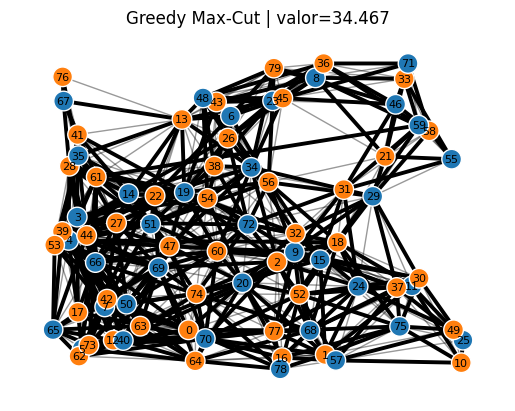

In [47]:
def maxcut(G, orden, tol=1e-12):
    """
    Dado un grafo, asigna un corte de forma greedy y luego
    aplica búsqueda local 1-flip reiniciando al mejorar.
    """
    # -----
    # Pasada constructiva
    # -----
    for v in orden:
        # probar lado 0 y su "flip" hipotético a 1
        side[v] = 0
        gain0 = -delta_flip(G, side, v)  # si está en 0 y lo flippeo a 1
        # probar lado 1 y su "flip" hipotético a 0
        side[v] = 1
        gain1 = -delta_flip(G, side, v)  # si está en 1 y lo flippeo a 0
        # quedarnos con el mejor lado
        side[v] = 0 if gain0 >= gain1 else 1

    # -----
    # Búsqueda local 1-flip (reiniciar al mejorar)
    # -----
    improved = True
    while improved:
        improved = False
        for v in orden:
            g = delta_flip(G, side, v)  # ganancia real si flippeo v ahora
            if g > tol:
                side[v] ^= 1  # aplicar flip
                improved = True
                break  # reinicia desde el inicio de 'orden'
    return side


# -----
# Partimos con un orden aleatorio
# -----
side = {v: 0 for v in G.nodes()}
order = list(G.nodes())
random.seed(7)
random.shuffle(order)

side_g = maxcut(G, order)
val_g = cut_weight(G, side_g)
print(f"Greedy Max-Cut: {val_g:.4f}")

# -----
# Visualización
# -----
vertices_corte = [(u, v) for u, v in G.edges() if side_g[u] != side_g[v]]
color_nodos = ["tab:blue" if side_g[v] == 0 else "tab:orange" for v in G.nodes()]
graficar_solucion(
    G,
    pos,
    color_nodos,
    edges_highlight=vertices_corte,
    title=f"Greedy Max-Cut | valor={val_g:.3f}",
)

Veamos que, algunas veces uno llega a un óptimo local tal que es difícil poder salir de tal solución, incluso con heurísticas como GRASP. Así, introducimos el ILS (Iterated Local Search). 

La idea es que, a partir de una solución greedy, perturbamos sutilmente $k$ vértices y volvemos a aplicar el algoritmo avaro. La idea es que estas perturbaciones nos ayuden a escapar de puntos silla.

In [32]:
import random


def ls_1flip(G, side, orden, tol=1e-12):
    """
    Realiza una búsqueda local 1-flip (first-improvement) sobre una asignación dada.
    Recorre los vértices en 'orden' y, si encuentra un flip que mejora el corte,
    lo aplica y reinicia el barrido desde el principio. Termina cuando ningún flip mejora.

    Parámetros:
    ------
    G : networkx.Graph
        Grafo
    side : dict
        Diccionario {nodo: 0/1} con la asignación actual del corte.
    orden : list
        Lista de nodos que define el orden de barrido de la búsqueda local.
    tol : float
        Tolerancia numérica: se considera mejora si delta_flip(G, side, v) > tol.

    Retorna:
    -------
    dict
        Diccionario {nodo: 0/1} con una solución óptima local respecto a movimientos 1-flip.
    """
    while True:
        for v in orden:
            if delta_flip(G, side, v) > tol:
                side[v] ^= 1  # aplicar flip # 0->1 1->0
                break  # reiniciar barrido desde el inicio de 'orden'
        else:
            # no se aplicó ningún flip en este barrido, entonces es un óptimo local
            break
    return side


def perturb(side, k, rng):
    """
    Perturba una solución de Max-Cut flippeando k vértices al azar.
    Útil para escapar de óptimos locales dentro de ILS.

    Parámetros:
    ------
    side : dict
        Diccionario {nodo: 0/1} con la solución actual.
    k : int
        Número de vértices a flippear aleatoriamente (si k > |V|, se limita a |V|).
    rng : random.Random
        Generador aleatorio (controlado por semilla externa para reproducibilidad).

    Retorna:
    -------
    dict
        Nueva solución {nodo: 0/1} tras aplicar la perturbación.
    """
    s = side.copy()
    vs = list(s.keys())
    rng.shuffle(vs)
    for v in vs[: min(k, len(vs))]:
        s[v] ^= 1
    return s


def ils_maxcut(G, iters=60, k=3, seed=None, tol=1e-12):
    """
    Iterated Local Search (ILS) mínimo para Max-Cut.
    Construye una solución inicial con greedy_maxcut.
    y luego repetir.

    Parámetros:
    ------
    G : networkx.Graph
        Grafo (con pesos en 'weight' o no ponderado).
    iters : int
        Número de iteraciones de ILS (ciclos perturbar+mejorar).
    k : int
        Intensidad de la perturbación (cantidad de nodos a flippear por iteración).
    seed : int | None
        Semilla para reproducibilidad (None = aleatorio).
    tol : float
        Tolerancia para considerar mejoras en la búsqueda local.

    Retorna:
    -------
    (dict, float)
        best_side : dict {nodo: 0/1} con la mejor asignación encontrada.
        best_val  : float valor del corte (suma de pesos de aristas cruzadas).
    """
    rng = random.Random(seed)
    orden = list(G.nodes())
    rng.shuffle(orden)

    # -----
    # Construcción inicial con greedy
    # -----
    global side
    side = {v: 0 for v in G.nodes()}
    side = maxcut(G, orden, tol)
    best = side.copy()
    best_val = cut_weight(G, side)

    # Ciclos de ILS
    for _ in range(iters):
        cand = perturb(side, k, rng)
        cand = ls_1flip(G, cand, orden, tol)
        val = cut_weight(G, cand)
        side = cand
        if val > best_val:
            best, best_val = cand.copy(), val

    return best, best_val

ILS Max-Cut: 34.5069


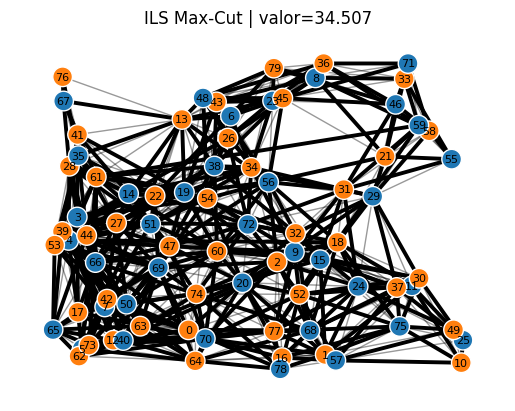

In [49]:
side_ils, val_ils = ils_maxcut(G, iters=15, k=5, seed=7)
print(f"ILS Max-Cut: {val_ils:.4f}")
edges_corte = [(u, v) for u, v in G.edges() if side_ils[u] != side_ils[v]]
color_nodos = ["tab:blue" if side_ils[v] == 0 else "tab:orange" for v in G.nodes()]
graficar_solucion(
    G,
    pos,
    color_nodos,
    edges_highlight=edges_corte,
    title=f"ILS Max-Cut | valor={val_ils:.3f}",
)

Para ver como afecta las perturbaciones, grafica como evoluciona la función objetivo al perturbar **sólamente un nodo** pero ir incrementando las iteraciones

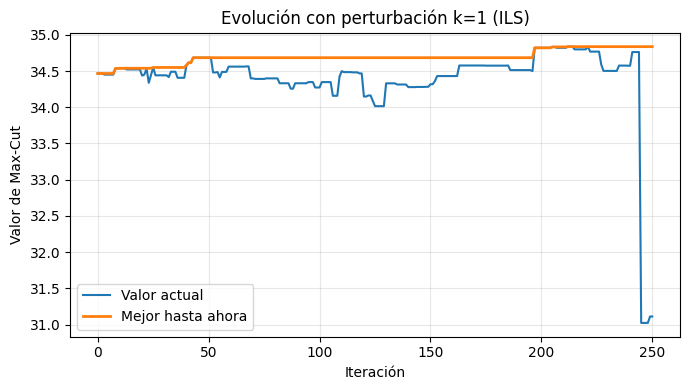

Mejor valor encontrado: 34.8371


In [50]:
import matplotlib.pyplot as plt


def graficarPerturbaciones(T, seed, k):
    """
    Grafica la mejor solución en función de las perturbaciones que uno va haciendo

    Parámetros
    ----------
    T: int
        Cantidad de iteraciones

    seed: int | none
       La semilla a utilizar

    k: int
        Cantidad de perturbaciones por iteraciones
    """
    """ 
    Programar 
    """


graficarPerturbaciones(250, 7, 1)

Ahora, repitan el gráfico con K = 5 y K = 10, K = 50. *¿Qué cambios pueden observar?* *¿Por qué no imponemos una perturbación lo más grande posible?*

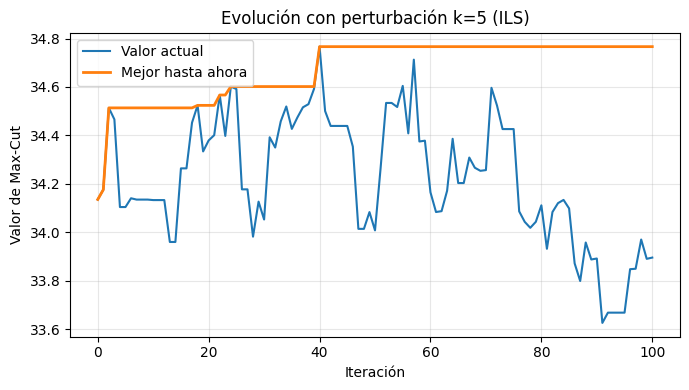

Mejor valor encontrado: 34.7666


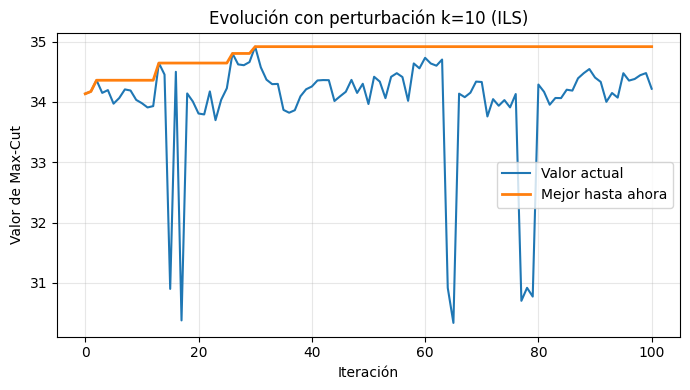

Mejor valor encontrado: 34.9166


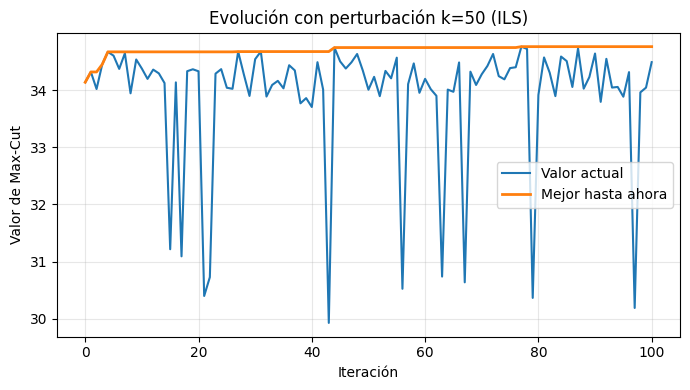

Mejor valor encontrado: 34.7582


In [36]:
graficarPerturbaciones(100, 7, 5)
graficarPerturbaciones(100, 7, 10)
graficarPerturbaciones(100, 7, 50)